<a href="https://colab.research.google.com/github/Cpt-Shaan/deep-stuff/blob/main/Sequential-Models/NMT_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Machine Translation (German to English) - Transformers using PyTorch

Implementation of Transformers architecture proposed in "Attention is All you need" by Vaswani et al., 2017 for machine translation.

In [ ]:
%%capture
# saving the files
# download the spacy language models for english and german
!python -m spacy download en --quiet
!python -m spacy download de --quiet

In [ ]:
%%capture
!pip install torchtext --upgrade

In [ ]:
!pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.18.0
    Uninstalling torchtext-0.18.0:
      Successfully uninstalled torchtext-0.18.0


Importing the necessary libraries

In [ ]:
from google.colab import drive
import math
import random
import time
import numpy as np
import seaborn as sns # For data visualization
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# spacy and torch-text for bleu-socre metric , dataset for NMT
import spacy
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [ ]:
# Initializing Device (GPU based on availibility)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Keeping a fixed seed for reproducing results

In [ ]:
SEED = 4444

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m spacy download de
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 54.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependenc

Data Loading and Pre-processing

In [ ]:
de_model = spacy.load('de_core_news_sm')
en_model = spacy.load('en_core_web_sm')

def de_tokenizer(sentence):
    return [token.text for token in de_model.tokenizer(sentence)]

def en_tokenizer(sentence):
    return [token.text for token in en_model.tokenizer(sentence)]

SOURCE_Field = Field(eos_token = '<src_eos>', init_token = '<src_sos>', lower = True, tokenize = de_tokenizer, batch_first = True)

TARGET_Field = Field(eos_token = '<trg_eos>', init_token = '<trg_sos>', lower = True, tokenize = en_tokenizer, batch_first = True)

A helper function to return input tensor corresponding to any string or list of tokens.

In [ ]:
def ipTensor(sentence, src_field):
    if isinstance(sentence, list):
        tokens = [src_field.init_token] + [token.lower() for token in sentence] + [src_field.eos_token]
    else:
        tokens = [src_field.init_token] + [token.text.lower() for token in de_tokenizer(sentence)] + [src_field.eos_token]
    seq_len = len(tokens)
    ip_tensor = torch.LongTensor([src_field.vocab.stoi[token] for token in tokens]).to(device)
    return ip_tensor.view(1, seq_len)

Downloaded the datasets from [here](https://github.com/multi30k/dataset/tree/master/data/task1/raw)


Fetching and splitting data into train, test and validation sets

In [ ]:
import os

# Assuming your downloaded files are named
#   - "train.de", "train.en" (for training)
#   - "val.de", "val.en" (for validation)
#   - "test_2017_flickr.de", "test_2017_flickr.en" (for testing)
# and are in the main directory of your Colab environment ("/content/")

train_de_path = "/content/train.de"
train_en_path = "/content/train.en"
val_de_path = "/content/val.de"
val_en_path = "/content/val.en"
test_de_path = "/content/test_2017_flickr.de"
test_en_path = "/content/test_2017_flickr.en"

# Create a temporary directory to mimic the expected structure
os.makedirs("/content/multi30k", exist_ok=True)

# Move the files to the temporary directory
os.rename(train_de_path, "/content/multi30k/train.de")
os.rename(train_en_path, "/content/multi30k/train.en")
os.rename(val_de_path, "/content/multi30k/val.de")
os.rename(val_en_path, "/content/multi30k/val.en")

# Create symbolic links for test files (or rename them if preferred)
os.symlink(test_de_path, "/content/multi30k/test2016.de")
os.symlink(test_en_path, "/content/multi30k/test2016.en")

# Now load the data using Multi30k.splits with the temporary directory
train_data, valid_data, test_data = Multi30k.splits(
    exts=('.de', '.en'),
    fields=(SOURCE_Field, TARGET_Field),
    root="/content"  # Set root to the parent of multi30k
)

In [ ]:
SOURCE_Field.build_vocab(train_data, min_freq = 2)
TARGET_Field.build_vocab(train_data, min_freq = 2)

print(f"Source vocab size: {len(SOURCE_Field.vocab)} | Target vocab size: {len(TARGET_Field.vocab)}")

Source vocab size: 7853 | Target vocab size: 5893


Model Architecture

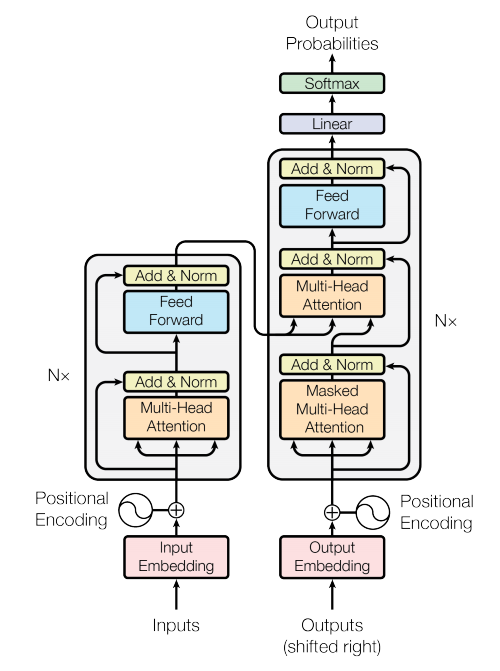

Keeping N = 3 for our implementation

Multihead Attention Class

In [ ]:
class MultiHead_Attn_Layer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout):
        super(MultiHead_Attn_Layer, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads
        self.fc_Q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_K = nn.Linear(hidden_dim, hidden_dim)
        self.fc_V = nn.Linear(hidden_dim, hidden_dim)
        self.fc_O = nn.Linear(hidden_dim, hidden_dim)
        self.scale = math.sqrt(self.head_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):                                    # [query] = [batch_size, query_len, hidden_dim] [key] = [batch_size, key_len, hidden_dim] [value] = [batch_Size, value_len, hidden_dim]
        batch_size = query.shape[0]
        Q = self.fc_Q(query)                                                            # [Q] = [batch_size, query_len, hidden_dim]
        K = self.fc_K(key)                                                              # [K] = [batch_size, key_len, hidden_dim]
        V = self.fc_V(value)                                                            # [V] = [batch_size, value_len, hidden_dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)     # [Q] = [batch_size, num_heads, query_len, head_dim]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)     # [K] = [batch_size, num_heads, key_len, head_dim]
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)     # [V] = [batch_size, num_heads, value_len, head_dim]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        if mask is not None:                                                            # [energy] = [batch_size, num_heads, query_len, key_len]
            energy = energy.masked_fill(mask == False, -1e10)
        attention = torch.softmax(energy, dim = -1)                                     # [attention] = [batch_size, num_heads, query_len, key_len]
        x = torch.matmul(self.dropout(attention), V)                                    # [x] = [batch_size, num_heads, query_len, head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()                                          # [x] = [batch_size, query_len, num_heads, head_dim]
        # Can avoid contiguous() if we use .reshape instead of .view in the next line
        out = self.fc_O(x.view(batch_size, -1, self.hidden_dim))                        # [out] = [batch_size, query_len, hidden_dim]
        return out, attention


Feed-Forward Neural Network (Takes Attention inputs)

In [ ]:
class Postn_Feed_Fwrd(nn.Module):
    def __init__(self, hidden_dim, pff_dim, dropout):
        super(Postn_Feed_Fwrd, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, pff_dim)
        self.fc2 = nn.Linear(pff_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):                                                   # input = [batch_size, seq_len, hidden_dim]
        out = torch.relu(self.fc1(input))                                       # out = [batch_size, seq_len, pff_dim]
        out = self.fc2(self.dropout(out))                                       # out = [batch_size, seq_len, hidden_dim]
        return out

Encoder Layer

In [ ]:
class Encoder_Layer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pff_dim, dropout):
        super(Encoder_Layer, self).__init__()
        self.self_attn = MultiHead_Attn_Layer(hidden_dim, n_heads, dropout)
        self.pff = Postn_Feed_Fwrd(hidden_dim, pff_dim, dropout)
        self.attn_norm = nn.LayerNorm(hidden_dim)
        self.pff_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):                                           # src = [batch_size, src_len, hidden_dim]  src_mask = [batch_size, src_len]
        attn_out, _ = self.self_attn(src, src, src, src_mask)                   # attn_out = [batch_size, src_len, hidden_dim]
        inter_out = self.attn_norm(self.dropout(attn_out) + src)                # inter_out = [batch_size, src_len, hidden_dim]
        pff_out = self.pff(inter_out)                                           # pff_out = [batch_size, src_len, hidden_dim]
        out = self.pff_norm(self.dropout(pff_out) + inter_out)                  # out = [batch_size, src_len, hidden_dim]
        return out


Positional Encoding (as used in the paper)

$$
\begin{aligned}
\text{PE}_{(pos, 2i)} &= \text{sin}(\frac{pos}{10000^{2i/d_{model}}}) \\
\text{PE}_{(pos, 2i + 1)} &= \text{cos}(\frac{pos}{10000^{2i/d_{model}}})
\end{aligned}
$$


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = hidden_dim
        self.max_len = max_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, self.d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:x.size(0), :]  # (batch_size, seq_len, d_model)
        x = self.dropout(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

Encoder Block

In [ ]:
class Encoder(nn.Module):
    def __init__(self, tok_vocab_size, pos_vocab_size, hidden_dim, enc_heads, enc_pff_dim, num_layers, enc_dropout):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(tok_vocab_size + 2, hidden_dim)
        # Adding 2 in tok_vocab_size to match dimensions with pre-trained weights which may have been trained on a different vocab size
        self.pos_embedding = nn.Embedding(pos_vocab_size, hidden_dim)
        self.enc_layers = nn.ModuleList([Encoder_Layer(hidden_dim, enc_heads, enc_pff_dim, enc_dropout) for i in range(num_layers)])
        self.scale = math.sqrt(hidden_dim)
        self.dropout = nn.Dropout(enc_dropout)

    def forward(self, src, src_mask):                                                       # src = [batch_size, src_len] src_mask = [batch_size, src_mask]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        tok_embed = self.tok_embedding(src)                                                 # tok_embed = [batch_size, src_len, hidden_dim]
        pos_tensor = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device) # pos_tensor = [batch_size, src_len]
        pos_embed = self.pos_embedding(pos_tensor)                                          # pos_embed = [batch_size, src_len, hidden_dim]
        enc_embed = self.dropout(tok_embed * self.scale + pos_embed)                        # enc_embed = [batch_size, src_len, hidden_dim]
        enc_state = enc_embed
        for enc_layer in self.enc_layers:
            enc_state = enc_layer(enc_state, src_mask)                                      # enc_state = [batch_size, src_len, hidden_dim]
        return enc_state

Decoder Layer

In [ ]:
class Decoder_Layer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pff_dim, dropout):
        super(Decoder_Layer, self).__init__()
        self.self_attn = MultiHead_Attn_Layer(hidden_dim, n_heads, dropout)
        self.cross_attn = MultiHead_Attn_Layer(hidden_dim, n_heads, dropout)
        self.pff = Postn_Feed_Fwrd(hidden_dim, pff_dim, dropout)
        self.attn_norm1 = nn.LayerNorm(hidden_dim)
        self.attn_norm2 = nn.LayerNorm(hidden_dim)
        self.pff_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, trg_mask, enc_out, src_mask):                            # trg = [batch_size, trg_len, hidden_dim] trg_mask = [batch_size, trg_len] enc_out = [batch_size, src_len, hidden_dim] src_mask = [batch_size, src_len]
        sattn_out, _ = self.self_attn(trg, trg, trg, trg_mask)                      # satten_out = [batch_size, trg_len, hidden_dim]
        inter_out1 = self.attn_norm1(self.dropout(sattn_out) + trg)                 # inter_out1 = [batch_size, trg_len, hidden_dim]
        cattn_out, attn = self.cross_attn(inter_out1, enc_out, enc_out, src_mask)   # cattn_out = [batch_size, trg_len, hidden_dim] attn = [batch_size, num_heads, query_len, key_len]
        inter_out2 = self.attn_norm2(self.dropout(cattn_out) + inter_out1)          # inter_out2 = [batch_size, trg_len, hidden_dim]
        pff_out = self.pff(inter_out2)                                              # pff_out = [batch_size, trg_len, hidden_dim]
        out = self.pff_norm(self.dropout(pff_out) + inter_out2)                     # out = [batch_size, trg_len, hidden_dim]
        return out, attn

Decoder Block

In [ ]:
class Decoder(nn.Module):
    def __init__(self, tok_vocab_size, pos_vocab_size, hidden_dim, dec_heads, dec_pff_dim, num_layers, dec_dropout):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(tok_vocab_size, hidden_dim)
        self.pos_embedding = nn.Embedding(pos_vocab_size, hidden_dim)
        self.dec_layers = nn.ModuleList([Decoder_Layer(hidden_dim, dec_heads, dec_pff_dim, dec_dropout) for i in range(num_layers)])
        self.fc = nn.Linear(hidden_dim, tok_vocab_size)
        self.scale = math.sqrt(hidden_dim)
        self.dropout = nn.Dropout(dec_dropout)

    def forward(self, trg, trg_mask, enc_out, src_mask):                                    # trg = [batch_size, trg_len] trg_mask = [batch_size, trg_len] enc_out = [] src_mask = []
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        tok_embed = self.tok_embedding(trg)                                                 # tok_embed = [batch_size, trg_len, hidden_dim]
        pos_tensor = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(device) # pos_tensor = [batch_size, trg_len]
        pos_embed = self.pos_embedding(pos_tensor)                                          # pos_embed = [batch_size, trg_len, hidden_dim]
        dec_embed = self.dropout(tok_embed * self.scale + pos_embed)                        # dec_embed = [batch_size, trg_len, hidden_dim]
        dec_state = dec_embed
        for dec_layer in self.dec_layers:
            dec_state, attention = dec_layer(dec_state, trg_mask, enc_out, src_mask)        # dec_state = [batch_size, trg_len, hidden_dim] attention = [batch_size, num_heads, query_len, key_len]
        out = self.fc(dec_state)                                                            # out = [batch_size, tok_vocab_size]
        return out, attention

Final Seq2Seq Transformer Architecture.


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_padding_idx, trg_padding_idx):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_padding_idx = src_padding_idx
        self.trg_padding_idx = trg_padding_idx

    def make_src_mask(self, src):                                                       # src = [batch_size, src_len]
        src_mask = (src != self.src_padding_idx).unsqueeze(1).unsqueeze(2).to(device)   # src_mask = [batch_size, 1, 1, src_len]
        return src_mask

    def make_trg_mask(self, trg):                                                       # trg = [batch_size, trg_len]
        trg_len = trg.shape[1]
        pad_mask = (trg != self.trg_padding_idx).unsqueeze(1).unsqueeze(2).to(device)   # pad_mask = [batch_size, 1, 1, trg_len]
        sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()   # sub_mask = [trg_len, trg_len]
        trg_mask = pad_mask & sub_mask                                                  # trg_mask = [batch_size, 1, trg_len, trg_len]
        return trg_mask

    def forward(self, src, trg):                                                        # src = [batch_size, src_len] trg = [batch_size, trg_len]
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, trg_mask, enc_out, src_mask)
        return output, attention

Training Function

In [ ]:
def Train(iterator, model, criterion, optimizer, clip):
    model.train()
    epoch_loss = 0
    for _, batch in enumerate(iterator):
        optimizer.zero_grad()
        source = batch.src
        target = batch.trg
        outputs, _ = model(source, target[:, :-1])
        outputs = outputs.contiguous().view(-1, outputs.shape[-1])
        targets = target[:, 1:].contiguous().view(-1).to(device)
        # To avoid using .contiguous() simply use .reshape instead of .conti..().view()
        batch_loss = criterion(outputs, targets)
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += batch_loss.item()

    return epoch_loss/len(iterator)

Evaluator Function

In [ ]:
def Evaluate(iterator, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            source = batch.src
            target = batch.trg
            outputs, attention = model(source, target[:, :-1])
            outputs = outputs.contiguous().view(-1, outputs.shape[-1])
            targets = target[:, 1:].contiguous().view(-1).to(device)
            # To avoid using .contiguous() simply use .reshape instead of .conti..().view()
            batch_loss = criterion(outputs, targets)
            eval_loss += batch_loss.item()

        return eval_loss/len(iterator)

def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

Hyperparameters and Initialization

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)
print("Number of Training sequences: ", len(train_data.examples))
print("Number of Test sequences: ", len(test_data.examples))
print("Number of Validation sequences: ", len(valid_data.examples))

Number of Training sequences:  29000
Number of Test sequences:  1000
Number of Validation sequences:  1014


In [ ]:
NUM_EPOCHS = 10
LR = 0.0005
CLIP = 1
SRC_VOCAB_SIZE = len(SOURCE_Field.vocab)
TRG_VOCAB_SIZE = len(TARGET_Field.vocab)
HIDDEN_DIM = 256
ENC_PFF_DIM = 512
DEC_PFF_DIM = 512
ENC_HEADS = 8
DEC_HEADS = 8
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
ENC_NUM_LAYERS = 3
DEC_NUM_LAYERS = 3
MAX_LEN = 100

In [ ]:
src_padding_idx = SOURCE_Field.vocab.stoi[SOURCE_Field.pad_token]
trg_padding_idx = TARGET_Field.vocab.stoi[TARGET_Field.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = trg_padding_idx)   # Loss function for the model

In [ ]:
encoder = Encoder(SRC_VOCAB_SIZE, MAX_LEN, HIDDEN_DIM, ENC_HEADS, ENC_PFF_DIM, ENC_NUM_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, MAX_LEN, HIDDEN_DIM, DEC_HEADS, DEC_PFF_DIM, DEC_NUM_LAYERS, DEC_DROPOUT).to(device)
seq2seq = Seq2Seq(encoder, decoder, src_padding_idx, trg_padding_idx).to(device)
optimizer = optim.AdamW(seq2seq.parameters(), LR)

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

seq2seq.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (enc_layers): ModuleList(
      (0-2): 3 x Encoder_Layer(
        (self_attn): MultiHead_Attn_Layer(
          (fc_Q): Linear(in_features=256, out_features=256, bias=True)
          (fc_K): Linear(in_features=256, out_features=256, bias=True)
          (fc_V): Linear(in_features=256, out_features=256, bias=True)
          (fc_O): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (pff): Postn_Feed_Fwrd(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attn_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (pff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
     

Loading the pre-trained weights

In [ ]:
MODEL_STORE_PATH = "Transformer.pth"

In [ ]:
seq2seq.load_state_dict(torch.load(MODEL_STORE_PATH, map_location = torch.device('cpu')), strict = False)

<All keys matched successfully>

Testing for inputs, and evaluation of the model

In [ ]:
seq2seq.eval()
test_loss = Evaluate(train_iterator, seq2seq, criterion)
print(f"Test Loss: {test_loss:.4f}  Test PPL: {math.exp(test_loss):.4f}")
# Calculating Peplexity (PPL) metric for better understanding of language models

In [ ]:
def Translate(src_sentence, src_field, trg_field, model):
    ip_tensor = ipTensor(src_sentence, src_field)
    max_len = 4 * ip_tensor.shape[1]
    src_mask = model.make_src_mask(ip_tensor)
    with torch.no_grad():
        enc_out = model.encoder(ip_tensor, src_mask)
    sos_id = trg_field.vocab.stoi[trg_field.init_token]
    eos_id = trg_field.vocab.stoi[trg_field.eos_token]
    predicts = [sos_id]
    for i in range(max_len):
        input = torch.LongTensor(predicts).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(input)
        with torch.no_grad():
            output, attention = model.decoder(input, trg_mask, enc_out, src_mask)
        predict_tok = output.argmax(2)[:, -1].item()
        predicts.append(predict_tok)
        if predict_tok == eos_id:
            break
    sentence = [trg_field.vocab.itos[id] for id in predicts[1:]]
    return sentence, attention

In [ ]:
ind = int(random.random() * len(test_data.examples))
example = test_data.examples[ind]
src_sentence = example.src
trg_sentence = example.trg
print("German Sentence: ", ' '.join(src_sentence))
translation, attention = Translate(src_sentence, SOURCE_Field, TARGET_Field, seq2seq)
print("Predicted Translation: ", ' '.join(translation[:-1]))
print("Actual Translation: ", ' '.join(trg_sentence))

German Sentence:  eine frau und ein hund rennen über eine wiese .
Predicted Translation:  a woman and a dog running through a grassy field .
Actual Translation:  a woman and a dog are running on a grassy field .


Displaying Attention between the input and output sentences for all the heads
(N_HEADS = 8)

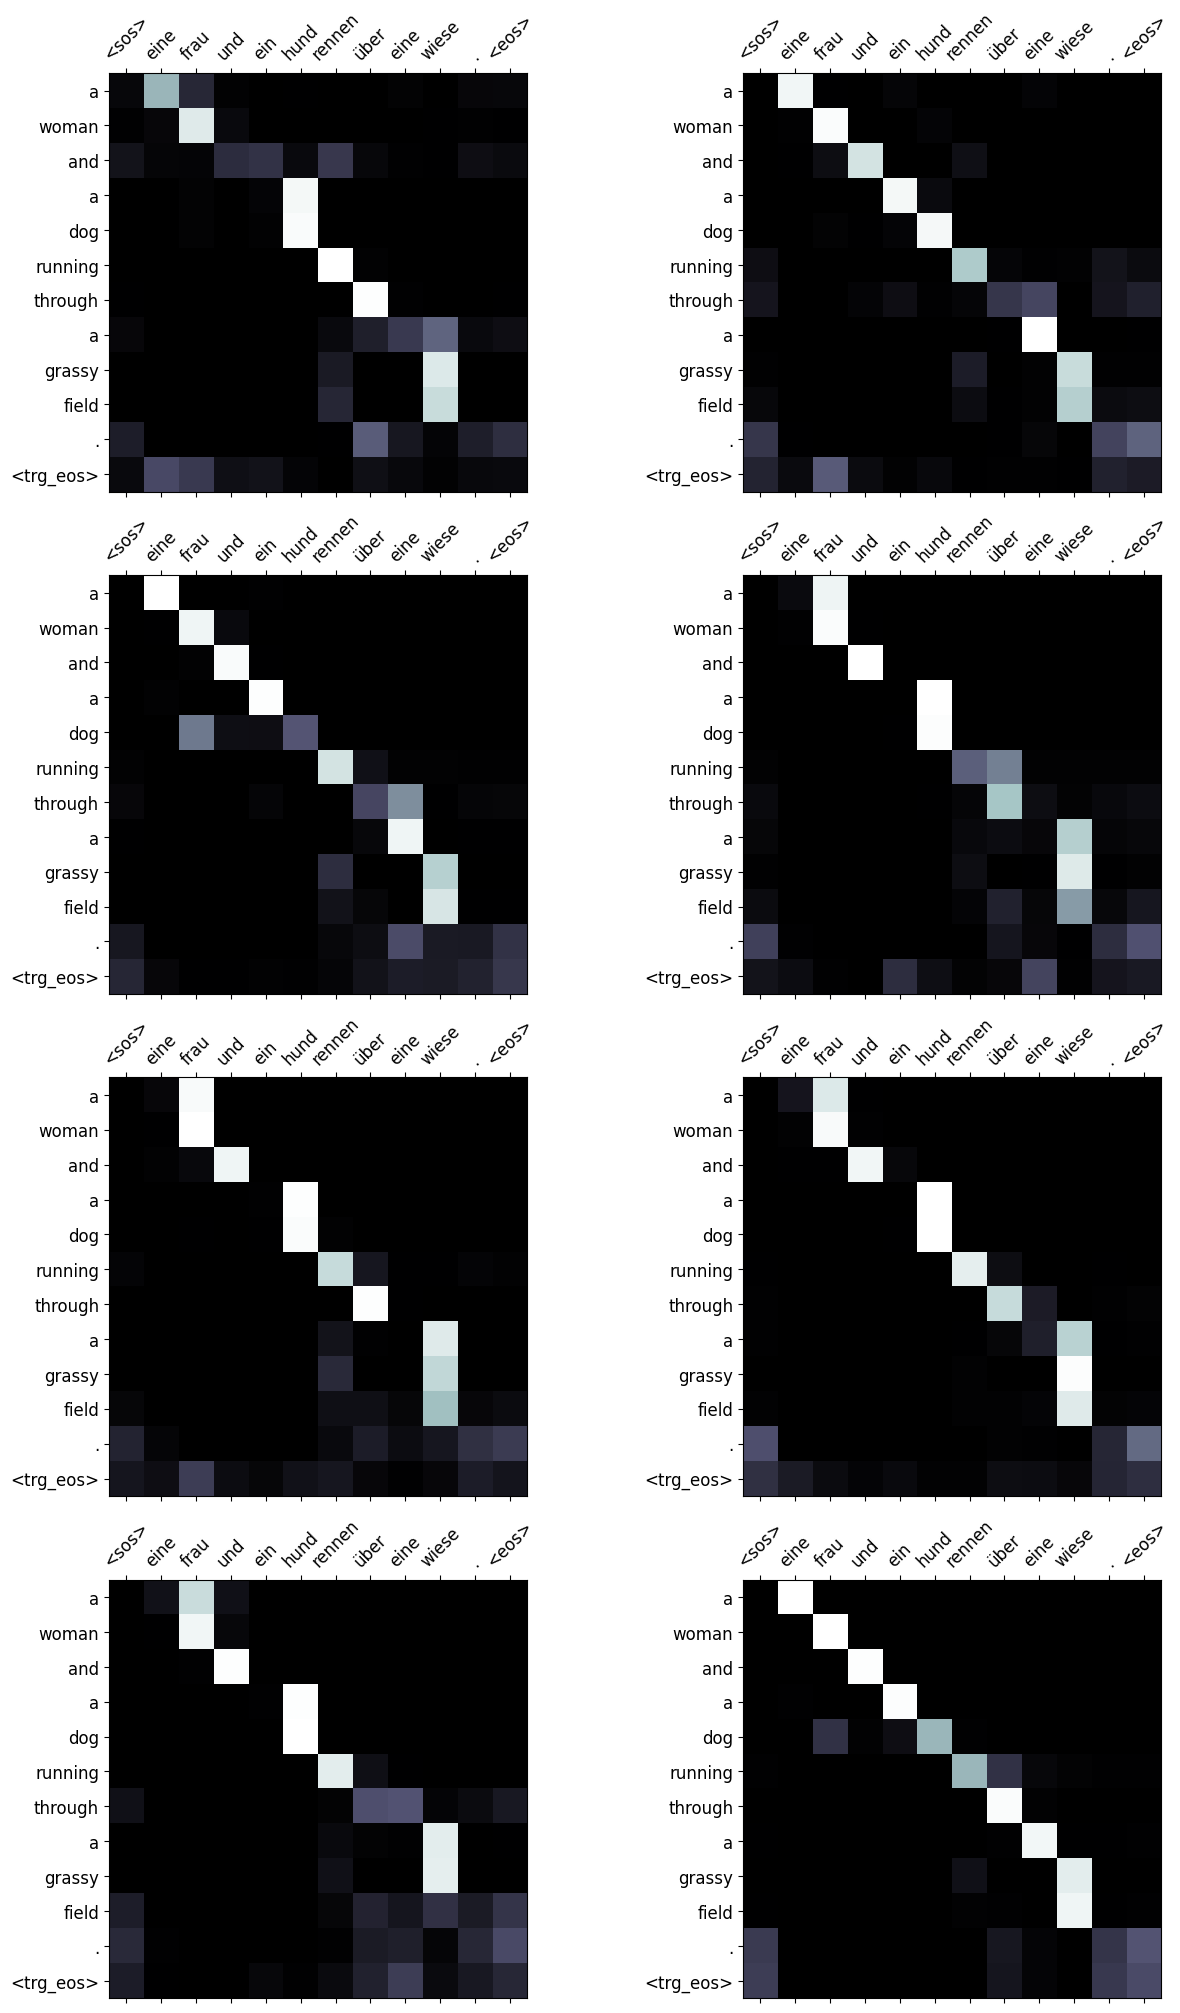

In [ ]:
def Disp_Attn(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
        ax.set_yticklabels(['']+translation)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

Disp_Attn(src_sentence, translation, attention)

Calculating BLEU Score (Metric for Machine Translation)

In [ ]:
def Calculate_BLEU(data, src_field, trg_field, model):
    trgs = []
    predicted_trgs = []
    for i in range(len(data.examples)):
        src_sentence = vars(data[i])['src']
        trg_sentence = vars(data[i])['trg']
        try:                                # Sometimes(rarely) CUDA throws a "Device side assert triggered" error. So, just to avoid restarting runtime.
            predicted_trg, _ = Translate(src_sentence, src_field, trg_field, model)
            predicted_trgs.append(predicted_trg[:-1])
            trgs.append([trg_sentence])
        except:
            pass
    return bleu_score(predicted_trgs, trgs)

bleu_score_test = Calculate_BLEU(test_data, SOURCE_Field, TARGET_Field, seq2seq)
print(f"BLEU score on Testing Data: {bleu_score_test*100:.2f}")

BLEU score on Testing Data: 23.22
